# 第五章 交叉编码器重排序

本节课，将使用交叉编码器重排序的技术，对检索到的结果进行相关性分析。重排序是一种根据结果与特定查询的相关性来排序和评分的方法。

<div class="toc">
    <ul class="toc-item">
        <li><span><a href="#一底层原理" data-toc-modified-id="一、底层原理">一、底层原理</a></span></li>
        <ul class="toc-item">
            <li><span><a href="#11-重排序" data-toc-modified-id="1.1 重排序">1.1 重排序</a></span></li>
            <li><span><a href="#12-交叉编码器" data-toc-modified-id="1.2 交叉编码器">1.2 交叉编码器</a></span></li>
        </ul>
        </li>
        <li><span><a href="#二实现过程" data-toc-modified-id="二、实现过程">二、实现过程</a></span></li>
        <ul class="toc-item">
            <li><span><a href="#21-导入辅助函数" data-toc-modified-id="2.1 导入辅助函数">2.1 导入辅助函数</a></span></li>
            <li><span><a href="#22-长尾部分的重排序" data-toc-modified-id="2.2 长尾部分的重排序">2.2 长尾部分的重排序</a></span></li>
            <li><span><a href="#23-结合查询扩展的重排序" data-toc-modified-id="2.3 结合查询扩展的重排序">2.3 结合查询扩展的重排序</a></span></li>
        </ul>
        </li>
    </ul>
</div>

## 一、底层原理

### 1.1 重排序

在得到特定查询的检索结果后，需要将该结果同查询一起输入到一个重排序模型中，使得最相关的结果具有最高的排名。
也就是说，重排序模型会根据查询来为每个结果打分，排名最高的结果就是与该查询最相关的结果。

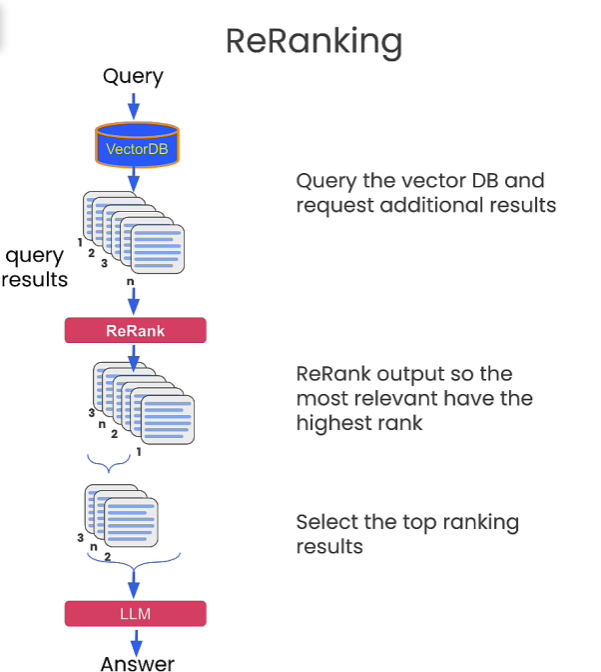

### 1.2 交叉编码器

BERT交叉编码器是句子转换器的一种模型，可以同时获取查询和文档，通过一个分类器对传入查询和每个检索到的文档打分，最后输出分数。

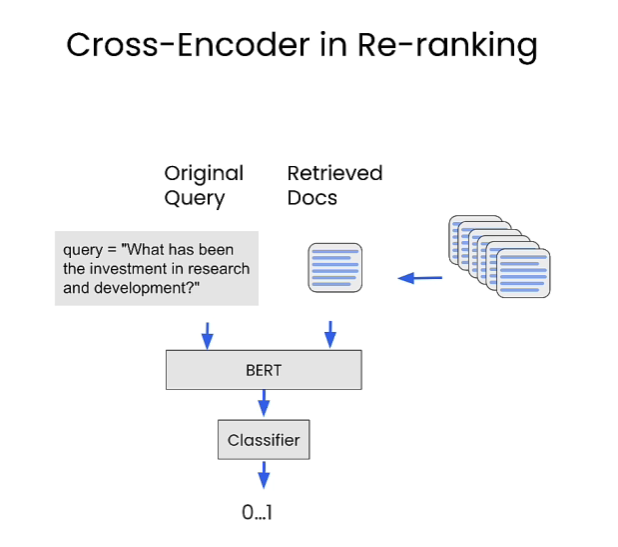

## 二、实现过程

### 2.1 导入辅助函数

In [1]:
from helper_utils import load_chroma, word_wrap, project_embeddings
import chromadb.utils.embedding_functions as embedding_functions
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction
import numpy as np

In [2]:
# 使用代理可能出现网络问题，将以下端口号1080全部替换成自己的vpn的端口号
import os
os.environ['HTTPS_PROXY']='http://127.0.0.1:1080'
os.environ["HTTP_PROXY"]='http://127.0.0.1:1080'

# 读取OpenAI的api key
# 在当前目录下创建.env文件（注意该文件没有后缀名）
# 文件内容为 OPENAI_API_KEY="sk-"（引号部分是自己的openai_api_key,通过登录openai官网，找到API keys就可以查询)
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) 
openai_api_key = os.environ['OPENAI_API_KEY']

# chromadb支持的嵌入函数有许多种，这里介绍常用的几种：
# 参考资料：https://docs.trychroma.com/embeddings
# 方式1：默认嵌入函数，需要下载模型，本地计算。英文文本表现不错，中文文本表现一般
# embedding_function = SentenceTransformerEmbeddingFunction()

# 方式2：OpenAI的嵌入函数，直接调用OpenAI的接口，无需下载模型(推荐)
embedding_function = embedding_functions.OpenAIEmbeddingFunction(
                api_key=openai_api_key,
                model_name="text-embedding-ada-002"
            )
# 方式3：HuggingFace的嵌入函数，需要下载模型，本地计算，对网络要求高
# embedding_function = embedding_functions.HuggingFaceEmbeddingFunction(
#     api_key="hf_",  # 填入你的 huggingface Access Token
#     model_name="jinaai/jina-embeddings-v2-base-zh"  # 指定模型
# )
## 中文备选模型
# jinaai/jina-embeddings-v2-base-zh
# GanymedeNil/text2vec-large-chinese
# BAAI/bge-large-zh-v1.5
# BAAI/bge-small-zh-v1.5


chroma_collection = load_chroma(filename='./data/北京2024年政府工作报告.pdf', collection_name='beijing_annual_report_2024', embedding_function=embedding_function,langcode='zh')
chroma_collection.count()

1028

### 2.2 长尾部分的重排序

In [3]:
# 之前一般设定返回5个结果，现在要求返回10个结果，加入了部分可能有用的的长尾结果
query = "地区生产总值是多少？"
results = chroma_collection.query(query_texts=query, n_results=10, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

for document in results['documents'][0]:
    print(word_wrap(document))
    print('')

全市地区生产总
值增长5.2%、约4.4万亿元

人均地区生产总值、全
员劳动生产率、万元地区生产总值能耗水耗等多项指标保持全国省级地区最优水平

数字经济增加值占地区生产总值比重达42.9%

提出今年全市经济社
会发展的主要预期目标是：地区生产总值增长5%左右

着力打造一批乡村产业强镇、优势特色产业集群

共同打造区域一流营商环境

居民消费价格总体平稳

居民消费价格涨幅3%左右

农业中关村总体框架基本形成

完成5.8万亩高标准农田建设



In [4]:
# BERT交叉编码器同时渠道查询和文档，通过一个分类器传递，获得一个得分
# 利用该得分作为检索结果的相关性或排名的得分
from sentence_transformers import CrossEncoder
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

In [5]:
pairs = [[query, doc] for doc in retrieved_documents]
scores = cross_encoder.predict(pairs)

print("分数和相应的文本:")

# 打印每个文档的分数和内容
for score, (query, document) in zip(scores, pairs):
    print(f"分数: {score}")
    print("文本:")
    print(word_wrap(document))
    print('')  # 在文档间添加空行以便区分

分数和相应的文本:
分数: 7.281142234802246
文本:
全市地区生产总
值增长5.2%、约4.4万亿元

分数: 8.211084365844727
文本:
人均地区生产总值、全
员劳动生产率、万元地区生产总值能耗水耗等多项指标保持全国省级地区最优水平

分数: 7.037868976593018
文本:
数字经济增加值占地区生产总值比重达42.9%

分数: 7.392502307891846
文本:
提出今年全市经济社
会发展的主要预期目标是：地区生产总值增长5%左右

分数: 4.40790319442749
文本:
着力打造一批乡村产业强镇、优势特色产业集群

分数: 6.061723709106445
文本:
共同打造区域一流营商环境

分数: 0.7508441209793091
文本:
居民消费价格总体平稳

分数: -2.1394357681274414
文本:
居民消费价格涨幅3%左右

分数: 1.561102032661438
文本:
农业中关村总体框架基本形成

分数: 2.6884243488311768
文本:
完成5.8万亩高标准农田建设



In [6]:
print("新排名:")
for o in np.argsort(scores)[::-1]:
    print(o+1)
print("分数和相应的文本:")
sorted_indices = np.argsort(scores)[::-1]

for rank, index in enumerate(sorted_indices, start=1):
    # 打印排名和对应的分数
    print(f"排名 {rank}, 分数: {scores[index]}")
    # 打印对应的文档内容，这里假设 pairs[index][1] 是文档内容
    print("文本:")
    print(pairs[index][1])
    print('')  # 在文档之间添加空行以便区分

新排名:
2
4
1
3
6
5
10
9
7
8
分数和相应的文本:
排名 1, 分数: 8.211084365844727
文本:
人均地区生产总值、全
员劳动生产率、万元地区生产总值能耗水耗等多项指标保持全国省级地区最优水平

排名 2, 分数: 7.392502307891846
文本:
提出今年全市经济社
会发展的主要预期目标是：地区生产总值增长5%左右

排名 3, 分数: 7.281142234802246
文本:
全市地区生产总
值增长5.2%、约4.4万亿元

排名 4, 分数: 7.037868976593018
文本:
数字经济增加值占地区生产总值比重达42.9%

排名 5, 分数: 6.061723709106445
文本:
共同打造区域一流营商环境

排名 6, 分数: 4.40790319442749
文本:
着力打造一批乡村产业强镇、优势特色产业集群

排名 7, 分数: 2.6884243488311768
文本:
完成5.8万亩高标准农田建设

排名 8, 分数: 1.561102032661438
文本:
农业中关村总体框架基本形成

排名 9, 分数: 0.7508441209793091
文本:
居民消费价格总体平稳

排名 10, 分数: -2.1394357681274414
文本:
居民消费价格涨幅3%左右



### 2.3 结合查询扩展的重排序

In [14]:
# 接下来把之前获得的结果排序前5名传递给LLM
original_query = "推动北京财政收入增长因素是什么"
generated_queries = [
    "什么推动了北京市的财政收入增长？",
    "什么对北京市的财政收入增长作出贡献？",
    "北京市财政收入增长依赖于什么？",
    "什么有助于北京市的财政收入增长？",
    "北京市财政收入增长受到哪些方面的影响？",
]

In [15]:
queries = [original_query] + generated_queries

results = chroma_collection.query(query_texts=queries, n_results=10, include=['documents', 'embeddings'])
retrieved_documents = results['documents']

In [16]:
# 删除检索文档中的重复数据
unique_documents = set()
for documents in retrieved_documents:
    for document in documents:
        unique_documents.add(document)

unique_documents = list(unique_documents)

In [17]:
# 再次创建pairs,可以增强查询的检索记过与原始查询的相关性
# 从中选择最佳的5个结果传递给LLM
pairs = []
for doc in unique_documents:
    pairs.append([original_query, doc])

In [18]:
scores = cross_encoder.predict(pairs)

In [19]:
print("分数和对应的文本:")

# 打印每个文档的分数和内容
for score, (query, document) in zip(scores, pairs):
    print(f"分数: {score}")
    print("文本:")
    print(word_wrap(document))
    print('')  # 在文档间添加空行以便区分

分数和对应的文本:
分数: 3.771892547607422
文本:
广大市民顾大局、讲奉献

分数: 7.265048027038574
文本:
促进北京普惠健
康保可持续发展

分数: 0.4265695810317993
文本:
增进民生福祉

分数: 3.892036199569702
文本:
更好赋能首都高质量发展
加快建设全球数字经济标杆城市

分数: 1.1407228708267212
文本:
一般公共预算收入增长8.2%、突破6000亿元

分数: 6.839895248413086
文本:
推动京津冀协同发展取得新的更大进展
牢牢牵住疏解非首都功能这个“牛鼻子”

分数: -1.744150996208191
文本:
经济整体回升向好

分数: 7.336371421813965
文本:
是中共北京市委带领全市人民攻坚克难、艰苦奋斗的结果

分数: 6.0403218269348145
文本:
我谨代
表北京市人民政府

分数: 2.5916125774383545
文本:
推动经济实现质的有效提升和量的合理增长

分数: 1.943619966506958
文本:
持续增加城乡居民收入

分数: 1.8531235456466675
文本:
加快首都规划体系建设

分数: 0.8338253498077393
文本:
居民收入增长与经济增长同步

分数: 6.78391170501709
文本:
绿色北京战略实施取得新成效

分数: 4.1538496017456055
文本:
加快形成消费和投资相互促进的良性循环

分数: 7.335842609405518
文本:
制定实施“北京服务”意见和促进民营经济发展壮大行动方案

分数: 6.128371238708496
文本:
提出今年全市经济社
会发展的主要预期目标是：地区生产总值增长5%左右

分数: 4.740273475646973
文本:
更好发挥积极财政政策作用

分数: -1.2582770586013794
文本:
全市新设企业增长
20.3%

分数: 5.123826503753662
文本:
为推进中国式现代化作出首都贡献

分数: 4.923649787902832
文本:
建设更高水平的平安北京

分数: -1.4023932218551636
文本:
发挥首都优势


In [20]:
# 打印新排名和对应的结果
print("新排名:")
for o in np.argsort(scores)[::-1]:
    print(o+1)
print("\n")
sorted_indices = np.argsort(scores)[::-1]
for rank, index in enumerate(sorted_indices, start=1):
    # 打印排名和对应的分数
    print(f"排名 {rank}, 分数: {scores[index]}")
    # 打印对应的文档内容，这里假设 pairs[index][1] 是文档内容
    print("文本:")
    print(pairs[index][1])
    print('')  # 在文档之间添加空行以便区分

新排名:
8
16
2
6
14
17
9
20
21
18
23
15
25
4
1
26
10
11
12
5
13
24
3
19
22
7


排名 1, 分数: 7.336371421813965
文本:
是中共北京市委带领全市人民攻坚克难、艰苦奋斗的结果

排名 2, 分数: 7.335842609405518
文本:
制定实施“北京服务”意见和促进民营经济发展壮大行动方案

排名 3, 分数: 7.265048027038574
文本:
促进北京普惠健
康保可持续发展

排名 4, 分数: 6.839895248413086
文本:
推动京津冀协同发展取得新的更大进展
牢牢牵住疏解非首都功能这个“牛鼻子”

排名 5, 分数: 6.78391170501709
文本:
绿色北京战略实施取得新成效

排名 6, 分数: 6.128371238708496
文本:
提出今年全市经济社
会发展的主要预期目标是：地区生产总值增长5%左右

排名 7, 分数: 6.0403218269348145
文本:
我谨代
表北京市人民政府

排名 8, 分数: 5.123826503753662
文本:
为推进中国式现代化作出首都贡献

排名 9, 分数: 4.923649787902832
文本:
建设更高水平的平安北京

排名 10, 分数: 4.740273475646973
文本:
更好发挥积极财政政策作用

排名 11, 分数: 4.72330379486084
文本:
提升市区街乡三级“服务包”工作
效能

排名 12, 分数: 4.1538496017456055
文本:
加快形成消费和投资相互促进的良性循环

排名 13, 分数: 3.930941581726074
文本:
提高财政投入力度

排名 14, 分数: 3.892036199569702
文本:
更好赋能首都高质量发展
加快建设全球数字经济标杆城市

排名 15, 分数: 3.771892547607422
文本:
广大市民顾大局、讲奉献

排名 16, 分数: 3.6102757453918457
文本:
切实提高财政金融服务效能

排名 17, 分数: 2.5916125774383545
文本:
推动经济实现质的有效提升和量的合理增长

排名 18, 分数: 1.94361996650